# Figure S11: Correlations between all model parameters describing inter-run and run durations modulations during sessions and across actions costs

## setup and imports

In [2]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fnmatch

from scipy.cluster.hierarchy import dendrogram, linkage, _plot_dendrogram
from scipy.cluster import hierarchy
import matplotlib.colors as mcolors

import warnings
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from utils import *
from plotting import *
from model_functions import *

plt.style.use('./Figures/paper.mplstyle')

In [3]:
rat_markers = {}
intact = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']

m, f = 0, 0
male_palette = create_teal_palette(num_shades=len([x for x in intact if 'M' in x]))
female_palette = create_blue_violet_palette(num_shades=len([x for x in intact if 'F' in x]), start_intensity=80)

for index, animal in enumerate(intact):
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[female_palette[f], 'o', '-']
        f += 1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[male_palette[m], 'o', '-']
        m += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

In [4]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']
names = ['alpha_0', 'alpha_t', 'alpha_u', 
         'gamma_0', 'gamma_t', 'gamma_u', 
         'mu_0', 'mu_t', 'mu_u', 
         'sigma_0', 'sigma_t', 'sigma_u']

alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
vars = [alpha_0, alpha_t, alpha_u, gamma_0, gamma_t, gamma_u, mu_0, mu_t, mu_u, sigma_0, sigma_t, sigma_u]
conds = ['60', '90', '120', '20', '10', '2', 'rev10', 'rev20']


# put all vars in a single dataframe
l = []
for animal in animalList:
    for cond in conds:
        _ = pd.DataFrame([[var[animal][cond] for var in vars]], columns=names)
        _["animal"] = animal
        _["condition"] = cond
        l.append(_)
df = pd.concat(l)


In [5]:
# manual y_limits, y_ticks and y_labels for the plots

lims = {'alpha_0': [0, 1, 2, 3],
        'alpha_t': [-0.1, 0, .1, .2, .3, .4, .5],
        'alpha_u': [-0.6, -0.4, -0.2, 0, 0.2, 0.4],
        'gamma_0': [0, 0.5, 1, 1.5, 2],
        'gamma_t': [-0.2, -.1, 0, 0.1],
        'gamma_u': [-.6, -.4, -.2, 0, .2],
        'mu_0': [.5, 1, 1.5, 2, 2.5],
        'mu_t': [0, 0.05, .1, .15, .2, ],
        'mu_u': [-.1, 0.0, .1, .2],
        'sigma_0': [0, .05, .1, .15, .2, .25],
        'sigma_t': [-.05, -.025, 0, .025, 0.05],
        'sigma_u': [-.03, 0, .03, .06, .09, .12]}

labels = {'alpha_0': r'$\alpha_0$', 'alpha_t': r"$\alpha_t$", 'alpha_u': r"$\alpha_u$",
          'gamma_0': r'$\gamma_0$', 'gamma_t': r"$\gamma_t$", 'gamma_u': r"$\gamma_u$",
          'mu_0': r'$\mu_0$', 'mu_t': r"$\mu_t$", 'mu_u': r"$\mu_u$",
          'sigma_0': r'$\sigma_0$', 'sigma_t': r"$\sigma_t$", 'sigma_u': r"$\sigma_u$"}


# S11B Correlation between parameters
(Need to define correlation first, and make S11A correlation matrix with S11B correlations)

alpha_u vs mu_u: 1.364x + -0.079, p=0.000, corrected=0.332, r=0.571


(3.3155875941302954e-05, 0.7554017817962094)

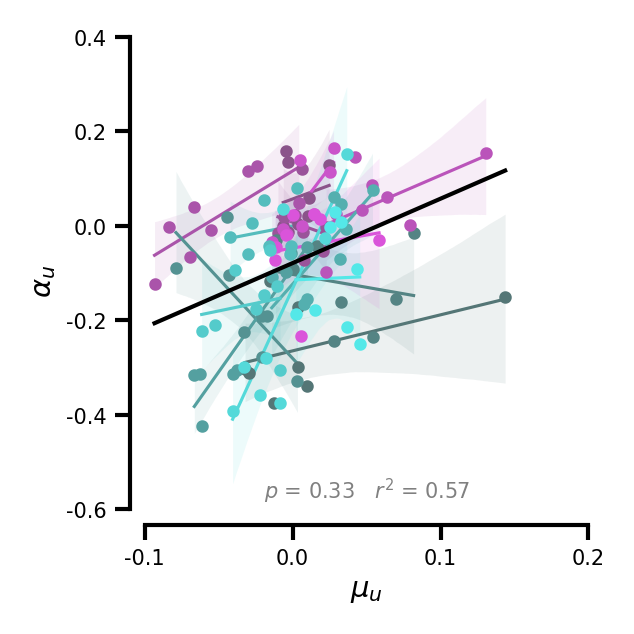

In [6]:
def FigureS11B(df, xname, yname, ax=None, _plot=False, bonferroni_correction=1):

    mdf = smf.mixedlm(f"{yname} ~ {xname}", df, groups=df["animal"]).fit()

    # https://cims.nyu.edu/~brenden/courses/labincp/chapters/15/00-mixed-effect.html
    # https://stats.stackexchange.com/questions/578134/linear-mixed-model-r2-calculation-using-statsmodels
    var_resid = mdf.scale
    var_random_effect = float(mdf.cov_re.iloc[0])
    var_fixed_effect = mdf.predict(df[xname]).var()
    total_var = var_fixed_effect + var_random_effect + var_resid
    marginal_r2 = var_fixed_effect / total_var
    conditional_r2 = (var_fixed_effect + var_random_effect) / total_var
    r = np.sqrt(conditional_r2) * np.sign(mdf.fe_params[xname])

    print(f'{yname} vs {xname}: {mdf.fe_params[xname]:.3f}x + {mdf.fe_params.Intercept:.3f}, p={mdf.pvalues[xname]:.3f}, corrected={mdf.pvalues[xname] * bonferroni_correction:.3f}, r={r**2:.3f}')


    if _plot:
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        xmin, xmax = 100, -100
        ymin, ymax = 100, -100
        for animal in animalList:
            x = df[df["animal"] == animal][xname]
            y = df[df["animal"] == animal][yname]

            ax.scatter(x, y, color=rat_markers[animal][0], zorder=2, s=4, marker=rat_markers[animal][1])

            # fit with np.polyfit
            f = lambda x, *p: np.polyval(p, x)
            p, cov = curve_fit(f, x, y, [1, 1])

            # calculate confidence intervals for fitted line
            xi = np.linspace(np.min(x), np.max(x), 100)
            ps = np.random.multivariate_normal(p, cov, 10000)
            ysample = np.asarray([f(xi, *pi) for pi in ps])
            lower = np.percentile(ysample, 2.5, axis=0)
            upper = np.percentile(ysample, 97.5, axis=0)

            # plot the regression and confidence intervals
            y_fit = np.poly1d(p)(xi)
            ax.plot(xi, y_fit, color=rat_markers[animal][0], lw=.75, zorder=1)

            # known issue (https://github.com/matplotlib/matplotlib/issues/22803): 
            # fill_between makes huge svg files, may be fixed in newer versions of matplotlib (here 3.3.4)
            ax.fill_between(xi, lower, upper, color=rat_markers[animal][0], alpha=.1, zorder=0, lw=0)

            xmin = min(xmin, np.min(x))
            xmax = max(xmax, np.max(x))
            ymin = min(ymin, np.min(y))
            ymax = max(ymax, np.max(y))

        xx = np.linspace(xmin, xmax, 100)
        yy = mdf.fe_params[xname] * xx + mdf.fe_params.Intercept
        ax.plot(xx, yy, color='k', lw=1, zorder=5)

        ax.set_xlabel(labels[xname])
        ax.set_ylabel(labels[yname])
        ax.set_xlim(lims[xname][0], lims[xname][-1])
        ax.set_ylim(lims[yname][0], lims[yname][-1])
        ax.set_xticks(lims[xname])
        ax.set_yticks(lims[yname])


        p = min(1, mdf.pvalues[xname] * bonferroni_correction)
        color = 'k' if p < 0.05 else 'gray'
        ax.annotate(f'{stars(p)}   $r^2$ = {conditional_r2:.2f}', xy=(.50, .1), color=color, xycoords='axes fraction', fontsize=5, ha='center', va='top')
        space_axes(ax)

    return mdf.pvalues[xname], r


FigureS11B(df, "mu_u", "alpha_u", _plot=True, bonferroni_correction=10000)

In [7]:
# Compare all variables
# fig, axs = plt.subplots(len(vars), len(vars), figsize=(3*len(vars), 3*len(vars)), dpi=300, constrained_layout=False)
# uncomment above and line 18 to plot all correlations (big figure)
if os.path.exists("picklejar/ModelCorrelations.p"):
    pvals, rvals = pickle.load(open("picklejar/ModelCorrelations.p", "rb"))
else:
    pvals = {}
    rvals = {}
    for i, (var1, name1) in enumerate(zip(vars, names)):
        pvals[name1] = {}
        rvals[name1] = {}
        for j, (var2, name2) in enumerate(zip(vars, names)):
            if i == j:
                # avoid nans
                pvals[name1][name2] = 1e-10
                rvals[name1][name2] = 1
            else:
                p, r = FigureS11B(df, name1, name2)#, axs[i, j])
                pvals[name1][name2] = p
                rvals[name1][name2] = r
    pickle.dump([pvals, rvals], open("picklejar/ModelCorrelations.p", "wb"))

# S11 A Correlation matrix and dendrograms between the 12 fitted model parameters capturing inter-run and run durations dynamics

66.0 tests, Corrected alpha = 0.0008


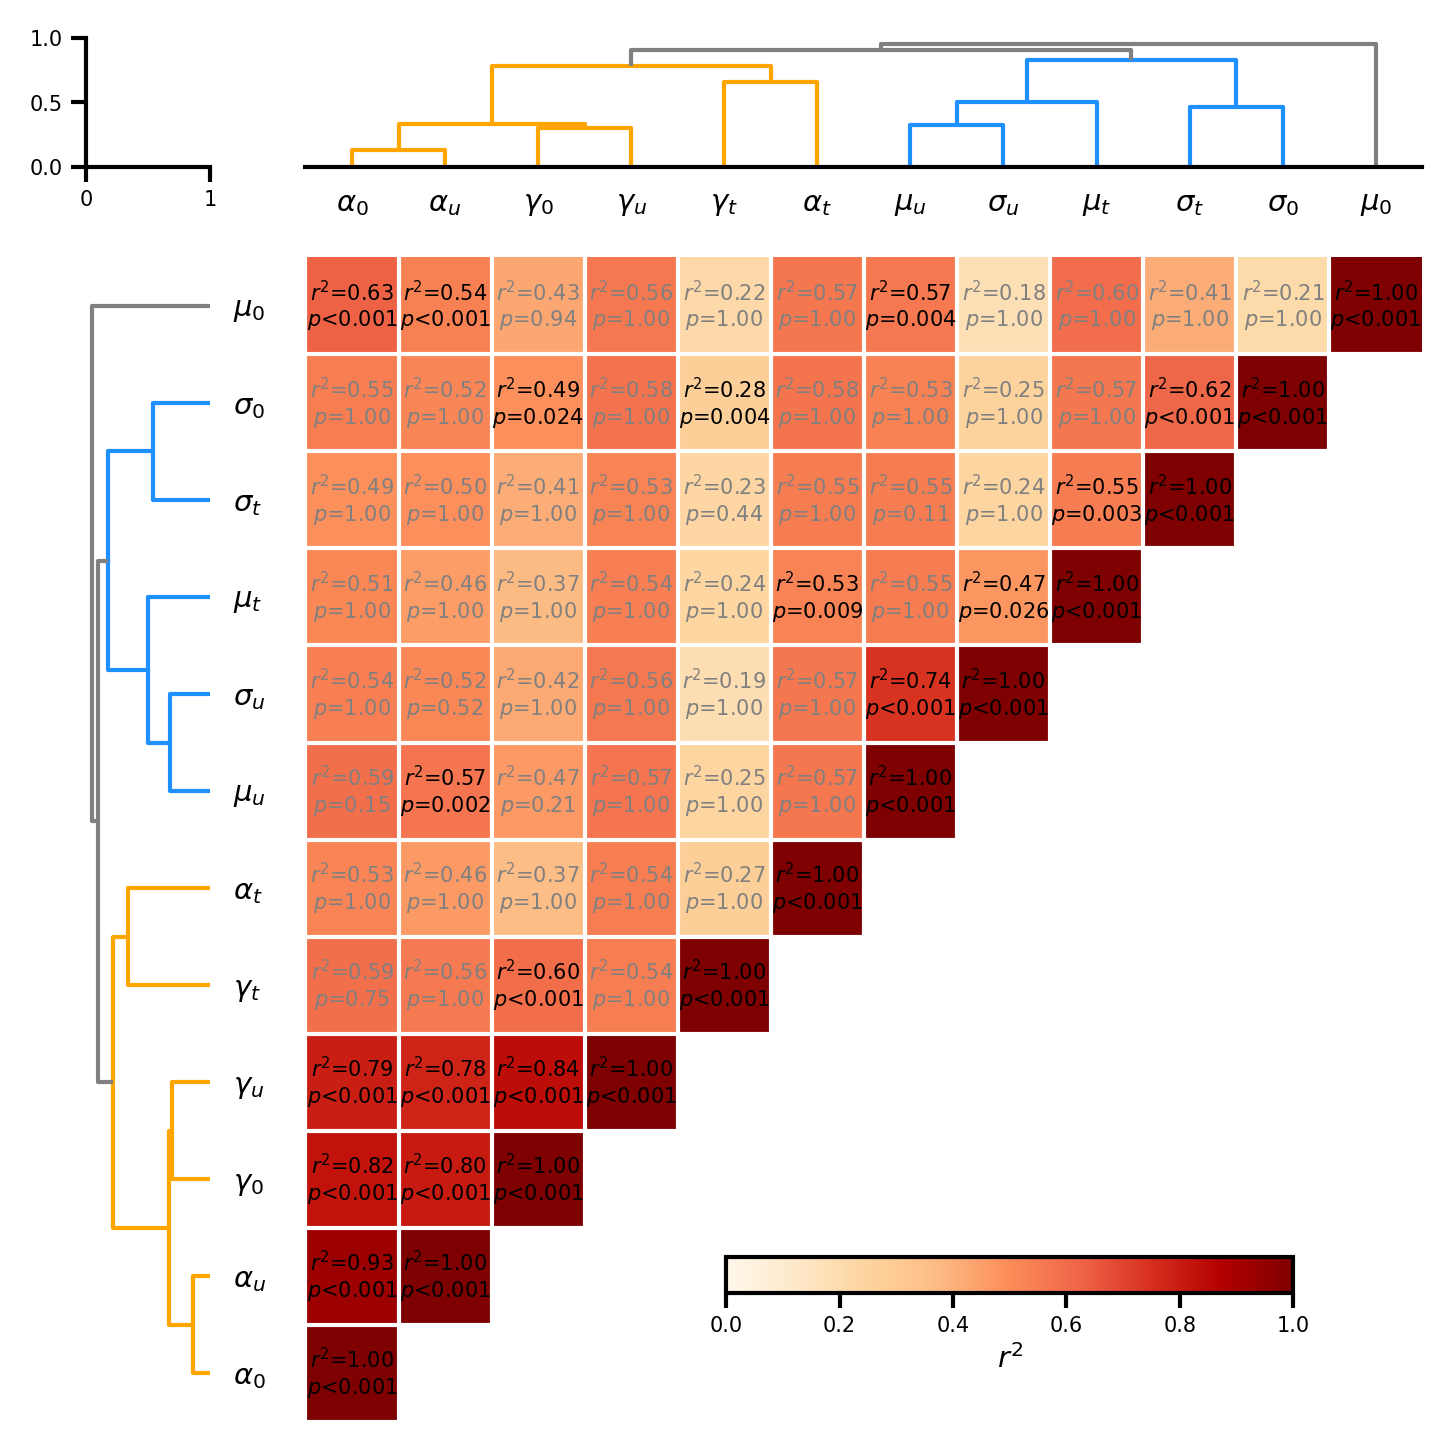

In [8]:
# correlation matrix and dendrogram.
# 2 versions: FigureS11A and Figure S11A_.
# FigureS11A_ is is the standard one, FigureS11A is the one with the hack to put mu_0 to the right
# of the dendrogram for less cluttering and better readability.

def FigureS11A_(rvals, pvals, labels, rsquared=True, axs=None):
    if axs is None:
        _, (_, ax_dendrogram_top, ax_dendrogram_left, ax_matrix) = plt.subplots(2, 2, figsize=(4, 4), gridspec_kw={'width_ratios': [1, 4], 'height_ratios': [1, 4]})
    else:
        ax_dendrogram_top, ax_dendrogram_left, ax_matrix = axs

    names = ['alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 
              'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']
    
    # Convert pvals to a 2D array
    p_values = np.zeros((len(names), len(names)))
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            p_values[i, j] = pvals[name1][name2]

    # Convert rvals to a 2D array
    correlations = np.zeros((len(names), len(names)))
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            correlations[i, j] = rvals[name1][name2]

    # Apply Bonferroni correction
    alpha = 0.05
    num_variables = len(labels)
    num_comparisons = num_variables * (num_variables - 1) / 2
    bonferroni_alpha = alpha / num_comparisons
    print(f'{num_comparisons} tests, Corrected alpha = {bonferroni_alpha:.4f}')
    # bonferroni_alpha = alpha
    significant_corr = p_values < bonferroni_alpha

    if rsquared:
        r = correlations.copy()
        correlations = correlations * correlations

    # Plot dendrograms
    hierarchy.set_link_color_palette(['orange', 'dodgerblue'])
    kwargs = {'labels':list(labels.values()), 'leaf_font_size':7, 'leaf_rotation':0, 'color_threshold':1.1, 'above_threshold_color':'gray'}
    Y = linkage(correlations, 'complete', optimal_ordering=True)
    Z2 = dendrogram(Y, orientation='top', ax=ax_dendrogram_top, **kwargs)
    ax_dendrogram_top.set_yticks([])
    ax_dendrogram_top.spines['left'].set_visible(False)

    Z2 = dendrogram(Y, orientation='left', ax=ax_dendrogram_left, **kwargs)
    ax_dendrogram_left.set_xticks([])
    ax_dendrogram_left.spines['left'].set_visible(False)
    ax_dendrogram_left.spines['bottom'].set_visible(False)

    # Plot  matrix with
    correlations = correlations[Z2['leaves'], :]
    correlations = correlations[:, Z2['leaves']]
    correlations = correlations.T
    correlations = np.tril(correlations, k=0)  # only upper triangle
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1) if i == 0 else plt.cm.OrRd(i) for i in range(256)])
    im = ax_matrix.matshow(correlations, aspect='auto', origin='lower', cmap=cmap, vmin=0, vmax=1)

    for i in range(len(labels)):
        ax_matrix.axhline(i - 0.5, color='white', linewidth=1)
        ax_matrix.axvline(i - 0.5, color='white', linewidth=1)

    ax_matrix.set_xticks([])
    ax_matrix.spines['bottom'].set_visible(False)
    ax_matrix.set_yticks([])
    ax_matrix.spines['left'].set_visible(False)

    for (i, j), val in np.ndenumerate(correlations):
        color = 'gray'
        if significant_corr[Z2['leaves'][i], Z2['leaves'][j]]:
            color = 'k'
        if i >= j:
            _p = min(1, p_values[Z2['leaves'][i], Z2['leaves'][j]] * num_comparisons)
            _p = ''.join(stars(_p).split())
            ax_matrix.text(j, i, f"$r^2$={val:.2f}\n{_p}",
                        ha='center', va='center', color=color, fontsize=5)
    return im, num_comparisons

def FigureS11A(rvals, pvals, labels, rsquared=True, axs=None):
    if axs is None:
        _, (_, ax_dendrogram_top, ax_dendrogram_left, ax_matrix) = plt.subplots(2, 2, figsize=(4, 4), gridspec_kw={'width_ratios': [1, 4], 'height_ratios': [1, 4]})
    else:
        ax_dendrogram_top, ax_dendrogram_left, ax_matrix = axs

    names = ['alpha_0', 'alpha_t', 'alpha_u', 'gamma_0', 'gamma_t', 'gamma_u', 
              'mu_0', 'mu_t', 'mu_u', 'sigma_0', 'sigma_t', 'sigma_u']
    
    # Convert pvals to a 2D array
    p_values = np.zeros((len(names), len(names)))
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            p_values[i, j] = pvals[name1][name2]

    # Convert rvals to a 2D array
    correlations = np.zeros((len(names), len(names)))
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            correlations[i, j] = rvals[name1][name2]

    # Apply Bonferroni correction
    alpha = 0.05
    num_variables = len(labels)
    num_comparisons = num_variables * (num_variables - 1) / 2
    bonferroni_alpha = alpha / num_comparisons
    print(f'{num_comparisons} tests, Corrected alpha = {bonferroni_alpha:.4f}')
    # bonferroni_alpha = alpha
    significant_corr = p_values < bonferroni_alpha

    if rsquared:
        r = correlations.copy()
        correlations = correlations * correlations

    # Plot dendrograms
    hierarchy.set_link_color_palette(['orange', 'dodgerblue'])
    kwargs = {'labels':list(labels.values()), 'leaf_font_size':7, 'leaf_rotation':0, 'color_threshold':1.1, 'above_threshold_color':'gray'}
    Y = linkage(correlations, 'complete', optimal_ordering=True)
    Z2 = dendrogram(Y, orientation='top', ax=ax_dendrogram_top, **kwargs, no_plot=True)

    #hack dendrogram, mu_0 to the right for consistency in the correlations (BC)
    for i in range(len(Z2['icoord'])):
        Z2['icoord'][i] = [x - 10 for x in Z2['icoord'][i]]
    Z2['icoord'][-1] = [115.0, 115.0, 61.875, 61.875]
    Z2["ivl"] = np.roll(Z2["ivl"], -1)
    Z2["leaves"] = np.roll(Z2["leaves"], -1)

    _plot_dendrogram(Z2["icoord"], Z2["dcoord"], Z2["ivl"], 30, 20, np.max(Z2["dcoord"]),
                    "top", False, Z2["color_list"], leaf_font_size=7, leaf_rotation=0, 
                    contraction_marks=None, above_threshold_color='gray', ax=ax_dendrogram_top)

    _plot_dendrogram(Z2["icoord"], Z2["dcoord"], Z2["ivl"], 30, 20, np.max(Z2["dcoord"]),
                    "left", False, Z2["color_list"], leaf_font_size=7, leaf_rotation=0, 
                    contraction_marks=None, above_threshold_color='gray', ax=ax_dendrogram_left)
                  
    ax_dendrogram_top.set_yticks([])
    ax_dendrogram_top.spines['left'].set_visible(False)
    ax_dendrogram_left.set_xticks([])
    ax_dendrogram_left.spines['left'].set_visible(False)
    ax_dendrogram_left.spines['bottom'].set_visible(False)


    # Plot  matrix with
    correlations = correlations[Z2['leaves'], :]
    correlations = correlations[:, Z2['leaves']]
    correlations = np.tril(correlations, k=0)  # only upper triangle
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [(1, 1, 1) if i == 0 else plt.cm.OrRd(i) for i in range(256)])
    im = ax_matrix.matshow(correlations, aspect='auto', origin='lower', cmap=cmap, vmin=0, vmax=1)

    for i in range(len(labels)):
        ax_matrix.axhline(i - 0.5, color='white', linewidth=1)
        ax_matrix.axvline(i - 0.5, color='white', linewidth=1)

    ax_matrix.set_xticks([])
    ax_matrix.spines['bottom'].set_visible(False)
    ax_matrix.set_yticks([])
    ax_matrix.spines['left'].set_visible(False)

    for (i, j), val in np.ndenumerate(correlations):
        color = 'gray'
        if significant_corr[Z2['leaves'][i], Z2['leaves'][j]]:
            color = 'k'
        if i >= j:
            _p = min(1, p_values[Z2['leaves'][i], Z2['leaves'][j]] * num_comparisons)
            _p = ''.join(stars(_p).split())
            ax_matrix.text(j, i, f"$r^2$={val:.2f}\n{_p}",
                        ha='center', va='center', color=color, fontsize=5)
    return im, num_comparisons


fig, axs = plt.subplots(2, 2, figsize=(cm2inch(12), cm2inch(12)), gridspec_kw={'width_ratios': [1, 9], 'height_ratios': [1, 9]})
_, ax_dendrogram_top, ax_dendrogram_left, ax_matrix = axs.ravel()
im, bc = FigureS11A(rvals, pvals, labels, axs=(ax_dendrogram_top, ax_dendrogram_left, ax_matrix))

axcolor = fig.add_axes([0.5, 0.1, 0.4, 0.025])
plt.colorbar(im, cax=axcolor, orientation='horizontal', label='$r^2$')

# Figure S11: Correlations between all model parameters describing inter-run and run durations modulations during sessions and across actions costs

66.0 tests, Corrected alpha = 0.0008
alpha_0 vs mu_0: 0.649x + 0.552, p=0.000, corrected=0.000, r=0.629
alpha_t vs mu_t: 1.032x + 0.105, p=0.000, corrected=0.009, r=0.528
alpha_u vs mu_u: 1.364x + -0.079, p=0.000, corrected=0.002, r=0.571
gamma_0 vs mu_0: 0.221x + 0.566, p=0.014, corrected=0.944, r=0.426
gamma_t vs mu_t: -0.184x + -0.050, p=0.133, corrected=8.795, r=0.236
gamma_u vs mu_u: 0.445x + -0.174, p=0.037, corrected=2.452, r=0.572


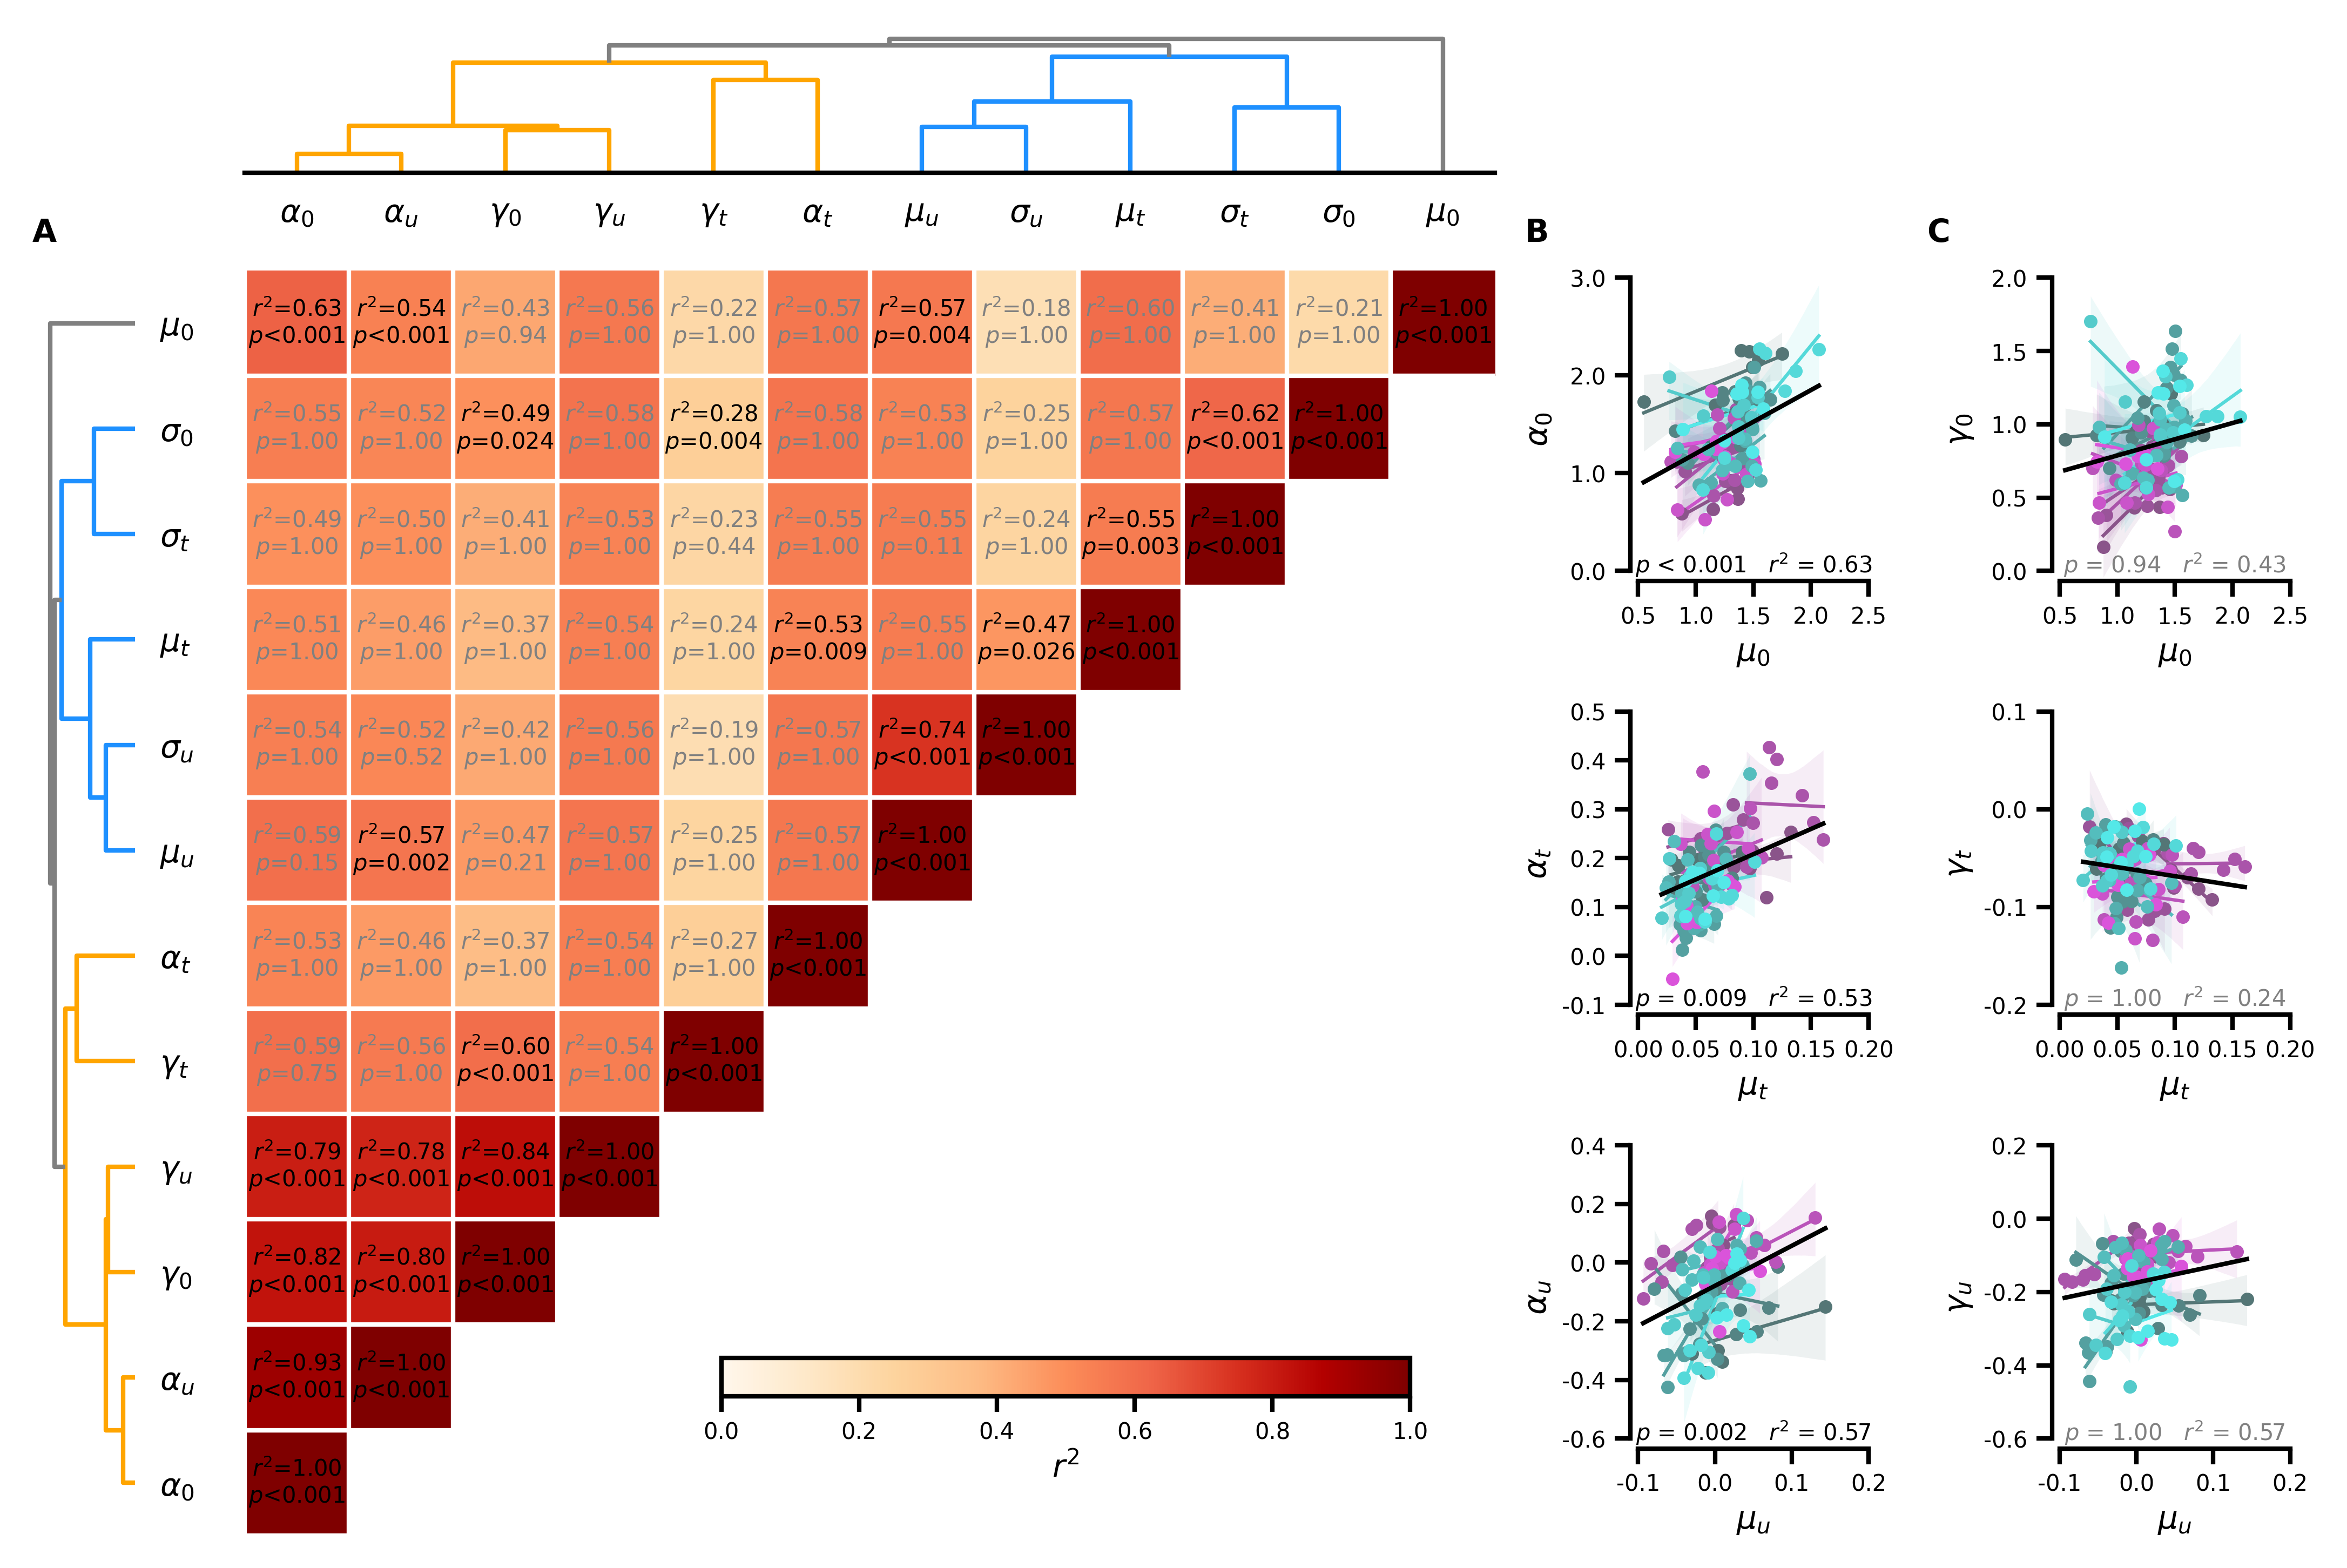

In [9]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(12)), 
               constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(1, 2, width_ratios=[1.8, 1], hspace=0.5)

left = gs0[0].subgridspec(2, 2, height_ratios=[1, 9], width_ratios=[1, 14])
dendrogram_top = plt.subplot(left[0, 1])
dendrogram_left = plt.subplot(left[1, 0])
matrix = plt.subplot(left[1, 1])

right = gs0[1].subgridspec(4, 2, width_ratios=[1, 1], height_ratios=[6, 9, 9, 9])
blk = plt.subplot(right[0, 1]).axis('off')
blk_ = plt.subplot(right[0, 0]).axis('off')
mu_0_alpha_0 = plt.subplot(right[1, 0])
mu_t_alpha_t = plt.subplot(right[2, 0])
mu_u_alpha_u = plt.subplot(right[3, 0])

mu_0_gamma_0 = plt.subplot(right[1, 1])
mu_t_gamma_t = plt.subplot(right[2, 1])
mu_u_gamma_u = plt.subplot(right[3, 1])

im, bc = FigureS11A(rvals, pvals, labels, axs=(dendrogram_top, dendrogram_left, matrix))
axcolor = fig.add_axes([0.3, 0.1, 0.3, 0.025])
plt.colorbar(im, cax=axcolor, orientation='horizontal', label='$r^2$')
FigureS11B(df, "mu_0", "alpha_0", _plot=True, ax=mu_0_alpha_0, bonferroni_correction=bc)
FigureS11B(df, "mu_t", "alpha_t", _plot=True, ax=mu_t_alpha_t, bonferroni_correction=bc)
FigureS11B(df, "mu_u", "alpha_u", _plot=True, ax=mu_u_alpha_u, bonferroni_correction=bc)

FigureS11B(df, "mu_0", "gamma_0", _plot=True, ax=mu_0_gamma_0, bonferroni_correction=bc)
FigureS11B(df, "mu_t", "gamma_t", _plot=True, ax=mu_t_gamma_t, bonferroni_correction=bc)
FigureS11B(df, "mu_u", "gamma_u", _plot=True, ax=mu_u_gamma_u, bonferroni_correction=bc)


axes = fig.get_axes()
for ax in axes[5:]:
    ax.yaxis.set_major_formatter('{x:>4.1f}')

figuresLabels={"A":[0.00, .85], "B":[0.65, 0.85], "C":[0.825, .85]}

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1], label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom', color='k')
    
plt.savefig("./Figures_paper/Figure_S11.pdf", facecolor='w', 
                edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("./Figures_paper/Figure_S11.svg", facecolor='w', 
                edgecolor='none', bbox_inches='tight', format="svg", dpi=600)